In [149]:
import xml.etree.ElementTree as ET
import os
from typing import List
from functools import reduce
from calendar import monthrange
import random
import matplotlib.pyplot as plt
import numpy as np
import json

In [150]:
import time

# Data Parsing and Processing

In [2]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [3]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [300]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [316]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


982.1077540000001

In [332]:
len(all_)

1685787

# Saving files locally and loading

In [328]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [409]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [410]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [414]:
save(0, all_[:600000])

34.48909100000037


In [415]:
l0 = load(0)

21.109441999999945


In [416]:
save(1, all_[600000:1200000])

42.26287699999966


In [417]:
l1 = load(1)

187.317133


In [418]:
save(2, all_[1200000:])

39.66254700000036


In [419]:
l2 = load(2)

18.493331000000126


In [421]:
l = l0 + l1 + l2
len(l)

1685787

In [305]:
t = time.process_time()
all06 = []
for i in range(1,13):
    all06 += get_docs_by_month(2006, i)
time.process_time() - t

35.79219599999999

In [304]:
len(all06)

85534

# Process by descriptor

In [306]:
t = time.process_time()
alld06 = {}
for doc in all06:
    for d in doc.descriptors:
        count, docs = alld06.get(d, (0, set()))
        docs.add(doc)
        alld06[d] = (count + 1, docs)
time.process_time() - t

0.8838240000000042

In [427]:
t = time.process_time()
alld = {}
for doc in l:
    doc = Doc(doc['id'], doc['gdescriptors'], doc['descriptors'], doc['text'])
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

20.75023999999985

In [16]:
alldlist06 = sorted([(d, alld06[d][0], alld06[d][1]) for d in alld06], key=lambda x: x[1], reverse=True)
for x in range(25):
    print(alldlist06[x][0:2])

('United States Politics and Government', 985)
('Books and Literature', 827)
('Politics and Government', 675)
('Computers and the Internet', 636)
('Travel and Vacations', 581)
('United States Armament and Defense', 557)
('Television', 511)
('Motion Pictures', 504)
('Basketball', 502)
('Baseball', 472)
('Art', 462)
('Medicine and Health', 444)
('Housing', 441)
('Theater', 432)
('Music', 403)
('Editorials', 394)
('Education and Schools', 381)
('Deaths (Obituaries)', 373)
('Economic Conditions and Trends', 333)
('Automobiles', 332)
('Mergers, Acquisitions and Divestitures', 330)
('Children and Youth', 319)
('Murders and Attempted Murders', 316)
('Restaurants', 310)
('Environment', 303)


In [48]:
computers = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld06['Computers and the Internet'][1]))

In [50]:
def inrange(c, lo, hi):
    return len(c.text.split(" ")) >= lo and len(c.text.split(" ")) <= hi

In [51]:
computersr = [c for c in computers if inrange(c, 500, 1500)]

In [53]:
len(computersr)

1061

In [43]:
len(computers)

1503

In [38]:
lens = []
for c in computers:
    lens.append(len(c.text.split(" ")))

In [56]:
np.mean(lens), np.median(lens), np.max(lens), np.min(lens)

(948.2388556220892, 892.0, 8290, 87)

(array([766., 664.,  51.,  10.,   3.,   2.,   2.,   1.,   1.,   3.]),
 array([  87. ,  907.3, 1727.6, 2547.9, 3368.2, 4188.5, 5008.8, 5829.1,
        6649.4, 7469.7, 8290. ]),
 <a list of 10 Patch objects>)

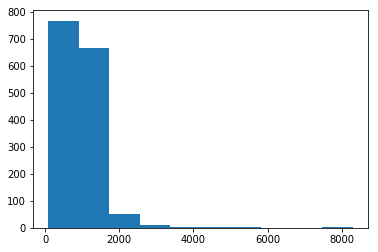

In [42]:
plt.hist(lens)

In [47]:
politics = list(filter(lambda x: 'Computers and the Internet' not in x.descriptors, \
                        alld06['Politics and Government'][1]))

In [34]:
lens2 = []
for c in politics:
    lens2.append(len(c.text.split(" ")))

In [35]:
np.mean(lens2), np.median(lens2), np.max(lens2), np.min(lens2)

(944.7611144042679, 824.0, 10083, 102)

(array([1.251e+03, 3.940e+02, 1.800e+01, 5.000e+00, 1.100e+01, 2.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([  102. ,  1100.1,  2098.2,  3096.3,  4094.4,  5092.5,  6090.6,
         7088.7,  8086.8,  9084.9, 10083. ]),
 <a list of 10 Patch objects>)

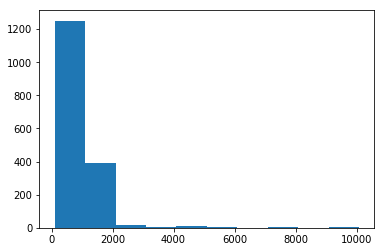

In [36]:
plt.hist(lens2)

In [44]:
computerss = random.sample(computers, 1500)

In [54]:
politicsr = [p for p in politics if inrange(p, 500, 1500)]

In [55]:
len(politicsr)

1276

In [45]:
len(politics)

1687

In [46]:
politicss = random.sample(politics, 1500)

In [59]:
politics[0].text

"I LEFT home -- and my front-row seat for observing Representative Harold Ford's apparently quixotic effort to take the Senate seat being vacated by Bill Frist -- two weeks ago to spend six days crossing the Atlantic by boat and a week using Jefferson's notes to retrace his tour of villages, gardens and great houses of southern England. What a difference a couple of weeks can make.I returned the other day to polls showing Mr. Ford in a statistical tie with his Republican opponent, Bob Corker. While anywhere else this might not seem like a big deal at this point, Tennessee isn't anywhere else.When I left, most folks I know, both old-time Southern Democrats and my new Republican neighbors in their McMansions, wouldn't have given the young black liberal from a family that seems always ready to stretch the bounds of propriety much of a chance in a statewide race. Particularly not against Mr. Corker, a very agreeable and successful former mayor of Chattanooga who easily K.O.'ed his more con

In [ ]:
with open("politics.txt", "w") as file:
    json.dump()

# Saving to json file

In [ ]:
test = json.loads(x)

# Training Word Embeddings

In [96]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [100]:
simple_preprocess(politics[10].text)[:10] # lowercasing, de-punctuation

['the',
 'house',
 'voted',
 'on',
 'thursday',
 'to',
 'approve',
 'oil',
 'and',
 'gas']

In [101]:
t = time.process_time()
docs = [simple_preprocess(t.text) for t in politics]
time.process_time() - t

2.3159149999999897

In [103]:
t = time.process_time()
model = Word2Vec(docs)
time.process_time() - t

12.638080000000002

In [115]:
t = time.process_time()
sg = Word2Vec(docs,sg=1)
time.process_time() - t

40.53857099999999

In [123]:
model.wv.most_similar(positive=['thursday'], topn=5)

[('tuesday', 0.9742521047592163),
 ('wednesday', 0.9678515195846558),
 ('monday', 0.9671248197555542),
 ('friday', 0.9400216341018677),
 ('saturday', 0.9233210682868958)]

In [126]:
model.wv.most_similar(positive=['approve'], topn=5)

[('pass', 0.906526505947113),
 ('override', 0.891733705997467),
 ('enact', 0.8751996159553528),
 ('muster', 0.8634128570556641),
 ('require', 0.8612051606178284)]

In [124]:
model.wv.most_similar(positive=['republican'], topn=10)

[('ohio', 0.8526729345321655),
 ('pennsylvania', 0.837384819984436),
 ('democrat', 0.8346357345581055),
 ('senator', 0.8219757080078125),
 ('democratic', 0.8156465888023376),
 ('arizona', 0.8087588548660278),
 ('tennessee', 0.783352255821228),
 ('senators', 0.7818459272384644),
 ('incumbent', 0.7785357236862183),
 ('tom', 0.7769345045089722)]

In [127]:
model.wv.most_similar(positive=['democrat'], topn=10)

[('representative', 0.9431465864181519),
 ('john', 0.9330054521560669),
 ('joseph', 0.9214594960212708),
 ('massachusetts', 0.908477783203125),
 ('illinois', 0.9078784584999084),
 ('senator', 0.9074325561523438),
 ('california', 0.9066224694252014),
 ('pennsylvania', 0.9062297940254211),
 ('thomas', 0.9041305184364319),
 ('nancy', 0.8977547287940979)]

In [119]:
model.wv.get_vector('democrat').shape

(100,)

# Summarization

In [84]:
from gensim.summarization.summarizer import summarize
from gensim.models import LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [95]:
politics[10].text

"The House voted on Thursday to approve oil and gas exploration in coastal waters that have been protected from drilling for 25 years.The vote was largely along party lines, 232 to 187, for a measure that would sharply expand efforts to make use of energy supplies beyond the Gulf of Mexico, the only area unaffected by executive branch and Congressional bans on drilling.''This is really the first major step in producing domestic energy that we have taken in almost 30 years,'' said Representative Richard W. Pombo, Republican of California, chairman of the House Resources Committee and the chief sponsor of the bill.Whether the drilling bans are ultimately eliminated depends on the Senate, where the chairman of the Energy Committee, Senator Pete V. Domenici, Republican of New Mexico, has been trying to build support for a measure that would expand oil and gas exploration in the gulf in an area west of Tampa, Fla., known as Lease Sale 181.Mr. Domenici still lacks enough support to win Senat

In [83]:
summarize(politics[10].text, word_count=200)

"In hours of debate before voting, Republicans repeatedly expressed a need to tap more of the resources that the United States controls, while Democrats argued for bills that encouraged conservation and placed a greater emphasis on renewable energy sources.Under the House bill, the federal moratorium would remain in effect up to 50 miles offshore unless a state petitioned the Interior Department to allow drilling.\n''Natural gas keeps us competitive until renewables become a bigger part of our energy portfolio.''Also on Thursday the Senate Appropriations Committee approved an amendment to the Interior Department appropriations bill that would punish companies that refused to renegotiate their offshore leases and pay full royalties during times of high prices.The amendment, sponsored by Senator Dianne Feinstein, Democrat of California, passed by a vote of 15 to 13, after the panel also passed an amendment from Mr. Domenici that encouraged the Interior Department to renegotiate their lea

In [79]:
s = summarize(politics[10].text)
len(s.split(" "))

64

In [64]:
print(summarize(text))

While anywhere else this might not seem like a big deal at this point, Tennessee isn't anywhere else.When I left, most folks I know, both old-time Southern Democrats and my new Republican neighbors in their McMansions, wouldn't have given the young black liberal from a family that seems always ready to stretch the bounds of propriety much of a chance in a statewide race.
Particularly not against Mr. Corker, a very agreeable and successful former mayor of Chattanooga who easily K.O.'ed his more conservative Republican opponents in the primary.In talking with my neighbors, however, I get the picture that several things are keeping the Ford campaign alive and thriving.
As Rick Warwick, my neighbor down the road and our county historian, told me recently, ''You know, Harold Ford is looking more and more like one of us.''After the primaries, everyone assumed that at this point, Mr. Corker would be way ahead in the polls, with the race maybe tightening toward the end.


In [71]:
t = time.process_time()
summaries_pol = [summarize(x.text) for x in politics]
time.process_time() - t

24.968287000000004

In [89]:
len(politics)

1687

# Measuring Bias

In [251]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())

In [275]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import bar

In [265]:
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

(54, 100)


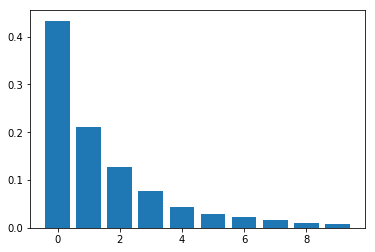

In [276]:
# borrowed from Bolukbasi et al
matrix = []
for a, b in pairs:
    if a not in model.wv.vocab or b not in model.wv.vocab:
        continue
    center = (model.wv.get_vector(a) + model.wv.get_vector(b))/2
    matrix.append(model.wv.get_vector(a) - center)
    matrix.append(model.wv.get_vector(b) - center)
matrix = np.array(matrix)
pca = PCA(n_components = 10)
pca.fit(matrix)
bar(range(10), pca.explained_variance_ratio_)
print(matrix.shape)

<BarContainer object of 10 artists>

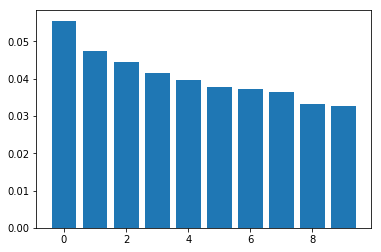

In [278]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(54,100))
bar(range(10), pca_r.explained_variance_ratio_)

In [281]:
pca.components_[0].shape

(100,)

In [293]:
g = pca.components_[0]

In [294]:
def gproj(w1):
    wvec = model.wv.get_vector(w1)
    p = np.dot(g, wvec)/np.linalg.norm(g)
    return p

In [297]:
for x in ['he', 'she', 'doctor', 'nurse', 'man', 'woman', 'male', 'female', 'math', 'dress']:
    print(x, gproj(x))

he 1.9921614
she -5.7593684
doctor -0.28550735
nurse -0.19783212
man -0.8884656
woman -1.7755088
male -0.41653666
female -0.21781293
math -0.14851217
dress -0.1319467


In [153]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [155]:
len(gender_specific)

218

In [156]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [158]:
len(gender_specific_full)

1441

In [161]:
gender_specific[:10]

['actress',
 'actresses',
 'aunt',
 'aunts',
 'bachelor',
 'ballerina',
 'barbershop',
 'baritone',
 'beard',
 'beards']

In [162]:
gender_specific_full[:10]

['he', 'his', 'He', 'her', 'she', 'him', 'She', 'man', 'women', 'men']

In [163]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())

In [298]:
profs[:5]

[['accountant', 0.0, 0.4],
 ['acquaintance', 0.0, 0.0],
 ['actor', 0.8, 0.0],
 ['actress', -1.0, 0.0],
 ['adjunct_professor', 0.0, 0.5]]

In [290]:
proflist = list(filter(lambda x: x in model.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [291]:
len(proflist)

123

In [194]:
# female - male vector

In [196]:
gendervec = model.wv.get_vector('he') - model.wv.get_vector('she')

In [246]:
mtest = model.wv.get_vector('woman') + model.wv.get_vector('he') - model.wv.get_vector('she')

In [247]:
model.most_similar(positive=[mtest], topn=1)

/Users/mayjiang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('chalabi', 0.49790534377098083)]

In [236]:
def get_proj(w1):
    gendervec = model.wv.get_vector('he') - model.wv.get_vector('she')
    wvec = model.wv.get_vector(w1)
    p = np.dot(gendervec, wvec)/np.linalg.norm(gendervec)
    return p

In [237]:
get_proj('him'), get_proj('it'), get_proj('she'), get_proj('he')

(0.35400337, 0.5252309, -5.5532165, 2.4317982)

In [243]:
get_proj('her'), get_proj('female'), get_proj('male')

(-6.870262, -0.32972872, -0.45655483)

In [244]:
get_proj('cat'), get_proj('hat'), get_proj('doctor'), get_proj('nurse')

(-0.053390913, -0.15381591, -0.39939, -0.24016267)

In [239]:
get_proj('woman'), get_proj('man'), get_proj('actor') 

(-1.9641705, -1.3020865, -0.07405841)

# Gender in WordNet

In [92]:
from nltk.corpus import wordnet

In [93]:
# use wordnet to determine if word is gendered or not?

In [191]:
p = wordnet.synsets('adult')[0]

In [192]:
p.hypernyms()

[Synset('person.n.01')]

In [193]:
# person -> performer -> actor
# person -> adult -> professional 
#        -> health professional -> medical practitioner -> doctor

In [143]:
f = wordnet.synsets('woman')[0]
m = wordnet.synsets('man')[0]

In [144]:
words = ['woman', 'man', 'queen', 'actress', 'king', 'actor', 'math', 'humanities', 'doctor']

In [248]:
# f.hyponyms(), f.hypernyms()

In [145]:
for w in words:
    wn = wordnet.synsets(w)[0]
    print(wn)
    print(f.wup_similarity(wn), m.wup_similarity(wn))

Synset('woman.n.01')
1.0 0.6666666666666666
Synset('man.n.01')
0.6666666666666666 1.0
Synset('queen.n.01')
0.6 0.6
Synset('actress.n.01')
0.6 0.6
Synset('king.n.01')
0.631578947368421 0.631578947368421
Synset('actor.n.01')
0.631578947368421 0.631578947368421
Synset('mathematics.n.01')
0.13333333333333333 0.13333333333333333
Synset('humanistic_discipline.n.01')
0.14285714285714285 0.14285714285714285
Synset('doctor.n.01')
0.5714285714285714 0.5714285714285714


In [249]:
# m.hyponyms(), m.hypernyms()